In [94]:
import tensorflow as tf
import glob
import pathlib
import os
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from collections import Counter
import PIL

In [95]:
# tf.debugging.set_log_device_placement(True)

In [96]:
REBUILD_DATA = True
data_dir = pathlib.Path("/content/dataset")

def data_count():
  CARDBOARD = os.path.join(data_dir, "cardboard")
  GLASS = os.path.join(data_dir, "glass")
  METAL = os.path.join(data_dir, "metal")
  PAPER = os.path.join(data_dir, "paper")
  PLASTIC = os.path.join(data_dir, "plastic")
  TRASH = os.path.join(data_dir, "trash")

  LABELS = {CARDBOARD: 0, GLASS: 1, METAL: 2, PAPER: 3, PLASTIC: 4, TRASH: 5}

  data = list()

  cardboardcount = 0
  glasscount = 0
  metalcount = 0
  papercount = 0
  plasticcount = 0
  trashcount = 0

  for label in LABELS:
    for file in os.listdir(label):
      file_path = os.path.join(label, file)
      if label == CARDBOARD:
        cardboardcount += 1
      elif label == GLASS:
        glasscount += 1
      elif label == METAL:
        metalcount += 1
      elif label == PAPER:
        papercount += 1
      elif label == PLASTIC:
        plasticcount += 1
      elif label == TRASH:
        trashcount += 1
    
  return cardboardcount, glasscount, metalcount, papercount, plasticcount, trashcount

In [97]:
cardboardcount, glasscount, metalcount, papercount, plasticcount, trashcount = data_count()
counts = [cardboardcount, glasscount, metalcount, papercount, plasticcount, trashcount]

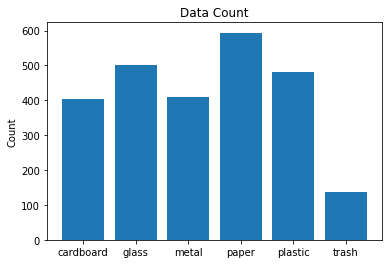

In [98]:
plt.bar(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], counts)
plt.title("Data Count")
plt.ylabel("Count")
plt.show()

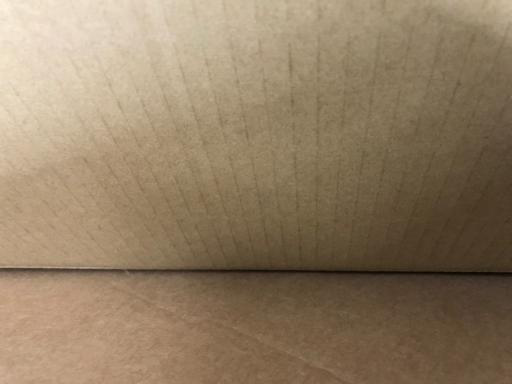

In [99]:
cardboard = list(data_dir.glob('cardboard/*'))
PIL.Image.open(str(cardboard[0]))

In [100]:
BATCH_SIZE = 128
IMG_SIZE = 224

In [101]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=41,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=41,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [102]:
class_names = train_ds.class_names

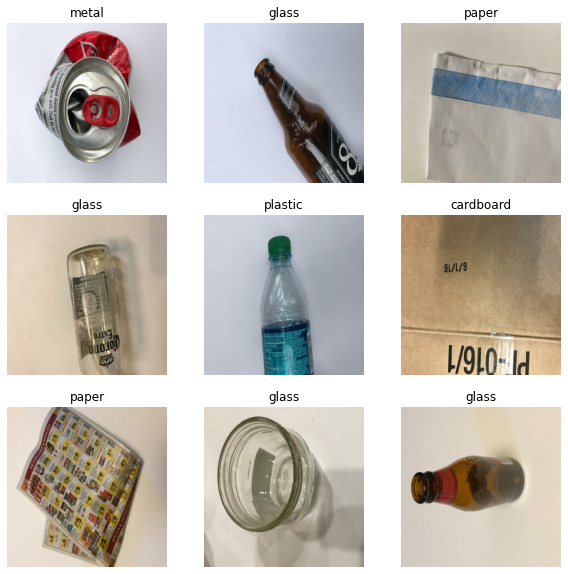

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [104]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape, labels_batch.shape)
  break

(128, 224, 224, 3) (128,)


In [105]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [106]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [107]:
normalised_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalised_ds))

first_image = image_batch[0]

# Basic Model

In [108]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [109]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
    )

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)       

In [111]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
16/16 [==============================] - 4s 229ms/step - loss: 2.0092 - accuracy: 0.2181 - val_loss: 1.6363 - val_accuracy: 0.2733
Epoch 2/10
16/16 [==============================] - 2s 142ms/step - loss: 1.4732 - accuracy: 0.4278 - val_loss: 1.3128 - val_accuracy: 0.4931
Epoch 3/10
16/16 [==============================] - 2s 148ms/step - loss: 1.2151 - accuracy: 0.5282 - val_loss: 1.2357 - val_accuracy: 0.5723
Epoch 4/10
16/16 [==============================] - 2s 152ms/step - loss: 1.0918 - accuracy: 0.5905 - val_loss: 1.2202 - val_accuracy: 0.5208
Epoch 5/10
16/16 [==============================] - 3s 157ms/step - loss: 0.9654 - accuracy: 0.6523 - val_loss: 1.2340 - val_accuracy: 0.5030
Epoch 6/10
16/16 [==============================] - 3s 168ms/step - loss: 0.8866 - accuracy: 0.6711 - val_loss: 1.1805 - val_accuracy: 0.5683
Epoch 7/10
16/16 [==============================] - 3s 170ms/step - loss: 0.8022 - accuracy: 0.6993 - val_loss: 1.1136 - val_accuracy: 0.5960
Epoch 

In [112]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [113]:
data_augmentation = Sequential(
    [
    layers.RandomFlip('horizontal',
                      input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
    ]
)

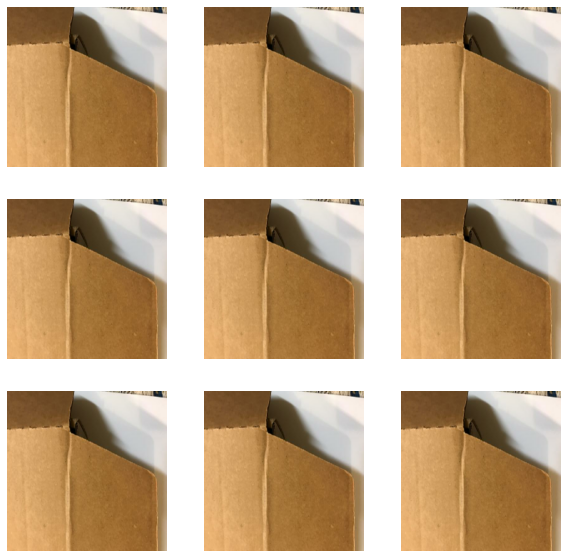

In [114]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    aug_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(aug_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [129]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])


model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
    )

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 56, 56, 64)      

In [130]:
EPOCHS = 50

checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[cp_callback]
)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.2613 - accuracy: 0.2146
Epoch 1: val_loss improved from inf to 1.69545, saving model to training/cp.ckpt
16/16 [==============================] - 3s 155ms/step - loss: 2.2613 - accuracy: 0.2146 - val_loss: 1.6955 - val_accuracy: 0.2317
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.5992 - accuracy: 0.3150
Epoch 2: val_loss improved from 1.69545 to 1.43349, saving model to training/cp.ckpt
16/16 [==============================] - 2s 146ms/step - loss: 1.5992 - accuracy: 0.3150 - val_loss: 1.4335 - val_accuracy: 0.4416
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.3828 - accuracy: 0.4496
Epoch 3: val_loss improved from 1.43349 to 1.32266, saving model to training/cp.ckpt
16/16 [==============================] - 2s 145ms/step - loss: 1.3828 - accuracy: 0.4496 - val_loss: 1.3227 - val_accuracy: 0.4851
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 1.3571

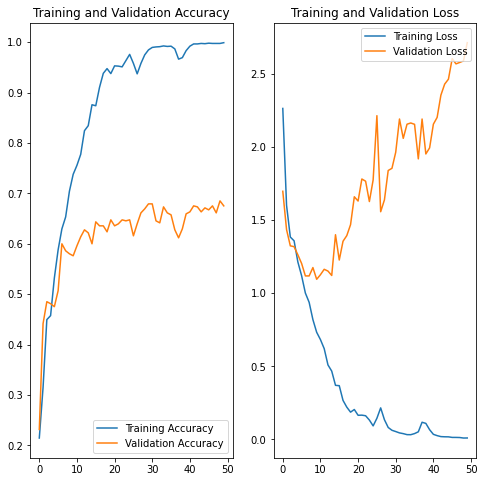

In [131]:
plot_history(history)

In [132]:
correct = 0
wrong = 0
LABELS = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
for label in (LABELS): 
  for file in (os.listdir(os.path.join("/content/dataset-resized", label))):
    file_path = os.path.join(label, file)
    img = tf.keras.utils.load_img(
       os.path.join("/content/dataset-resized", file_path), target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)].lower() == label.lower():
      correct += 1
    else:
      wrong += 1


In [133]:
correct, wrong

(2354, 173)